<a href="https://colab.research.google.com/github/MoFahad2921/Prediction-Model_Ensembling_ParameterTuning/blob/main/DataMining_FA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/Walmart_Store_sales.xlsx"
df = pd.read_excel(file_path)

Mounted at /content/drive


In [2]:
df['Date'] = pd.to_datetime(df['Date'])

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week.astype(int)


In [3]:
holiday_dates = pd.to_datetime([
    '2010-02-12','2011-02-11','2012-02-10','2013-02-08',
    '2010-09-10','2011-09-09','2012-09-07','2013-09-06',
    '2010-11-26','2011-11-25','2012-11-23','2013-11-29',
    '2010-12-31','2011-12-30','2012-12-28','2013-12-27'
])

df['Days_To_Holiday'] = df['Date'].apply(
    lambda x: min(abs((x - h).days) for h in holiday_dates)
)

In [4]:
df = df.sort_values('Date')

train = df[df['Date'] < '2012-01-01']
test  = df[df['Date'] >= '2012-01-01']

X_train = train.drop(['Weekly_Sales', 'Date'], axis=1)
y_train = train['Weekly_Sales']

X_test = test.drop(['Weekly_Sales', 'Date'], axis=1)
y_test = test['Weekly_Sales']

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

lr = LinearRegression()
lr.fit(X_train, y_train)

pred_lr = lr.predict(X_test)

print("MAE:", mean_absolute_error(y_test, pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred_lr)))

MAE: 423220.84749499033
RMSE: 518854.32719379285


In [6]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

print("RF MAE:", mean_absolute_error(y_test, pred_rf))
print("RF RMSE:", np.sqrt(mean_squared_error(y_test, pred_rf)))


RF MAE: 178052.2200331151
RF RMSE: 291289.6988024372


In [7]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    random_state=42
)

gbr.fit(X_train, y_train)
pred_gbr = gbr.predict(X_test)

print("GBR MAE:", mean_absolute_error(y_test, pred_gbr))
print("GBR RMSE:", np.sqrt(mean_squared_error(y_test, pred_gbr)))


GBR MAE: 129128.99215805945
GBR RMSE: 207784.970417625


In [8]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [200, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

grid.fit(X_train, y_train)

grid.best_params_


{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

In [9]:
#Feature Importance
import pandas as pd

importance = pd.Series(
    gbr.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importance.head(10)


,0
Store,0.645488
CPI,0.167887
Unemployment,0.101240
Week,0.050930
Days_To_Holiday,0.014529
Temperature,0.011134
Fuel_Price,0.004815
Month,0.001754
Holiday_Flag,0.001484
Year,0.000740


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 6435 entries, 606 to 283
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Store            6435 non-null   int64         
 1   Date             6435 non-null   datetime64[ns]
 2   Weekly_Sales     6435 non-null   float64       
 3   Holiday_Flag     6435 non-null   int64         
 4   Temperature      6435 non-null   float64       
 5   Fuel_Price       6435 non-null   float64       
 6   CPI              6435 non-null   float64       
 7   Unemployment     6435 non-null   float64       
 8   Year             6435 non-null   int32         
 9   Month            6435 non-null   int32         
 10  Week             6435 non-null   int64         
 11  Days_To_Holiday  6435 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int32(2), int64(4)
memory usage: 603.3 KB


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week,Days_To_Holiday
count,6435.000000,6435,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,2011-06-17 20:18:27.692307712,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151,2010.965035,6.475524,26.000000,38.356643
min,1.000000,2010-01-10 00:00:00,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000,2010.000000,1.000000,1.000000,0.000000
25%,12.000000,2010-10-12 00:00:00,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000,2010.000000,4.000000,14.000000,14.000000
50%,23.000000,2011-06-17 00:00:00,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000,2011.000000,6.000000,26.000000,29.000000
75%,34.000000,2012-03-02 00:00:00,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000,2012.000000,9.000000,38.000000,63.000000
max,45.000000,2012-12-10 00:00:00,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000,2012.000000,12.000000,52.000000,105.000000
std,12.988182,NaN,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885,0.797019,3.321797,14.511794,30.538012


In [12]:
df.isna().sum()

,0
Store,0
Date,0
Weekly_Sales,0
Holiday_Flag,0
Temperature,0
Fuel_Price,0
CPI,0
Unemployment,0
Year,0
Month,0


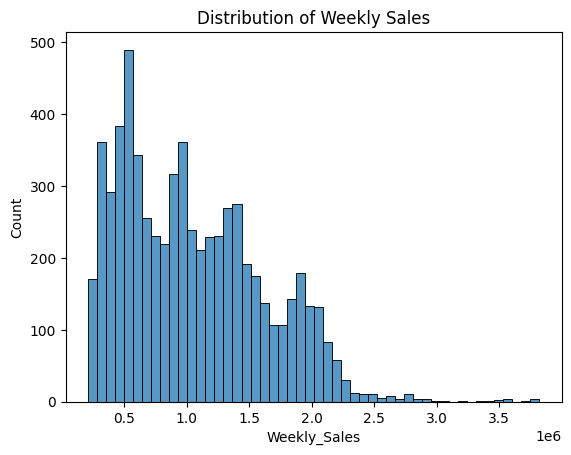

In [13]:
plt.figure()
sns.histplot(df['Weekly_Sales'], bins=50)
plt.title("Distribution of Weekly Sales")
plt.show()

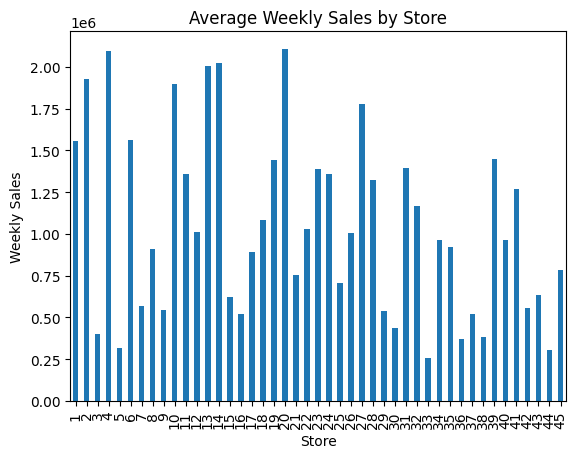

In [14]:
store_sales = df.groupby('Store')['Weekly_Sales'].mean()

plt.figure()
store_sales.plot(kind='bar')
plt.title("Average Weekly Sales by Store")
plt.ylabel("Weekly Sales")
plt.show()


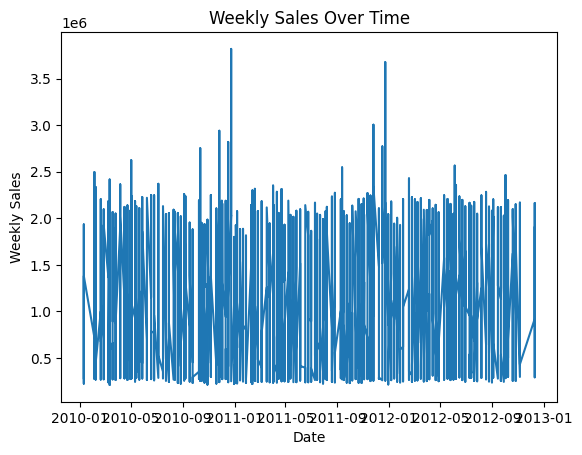

In [15]:
df['Date'] = pd.to_datetime(df['Date'])

plt.figure()
plt.plot(df['Date'], df['Weekly_Sales'])
plt.title("Weekly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.show()


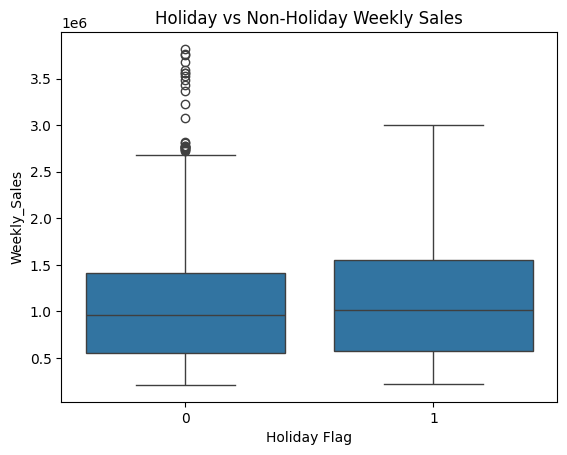

In [16]:
plt.figure()
sns.boxplot(x='Holiday_Flag', y='Weekly_Sales', data=df)
plt.title("Holiday vs Non-Holiday Weekly Sales")
plt.xlabel("Holiday Flag")
plt.show()


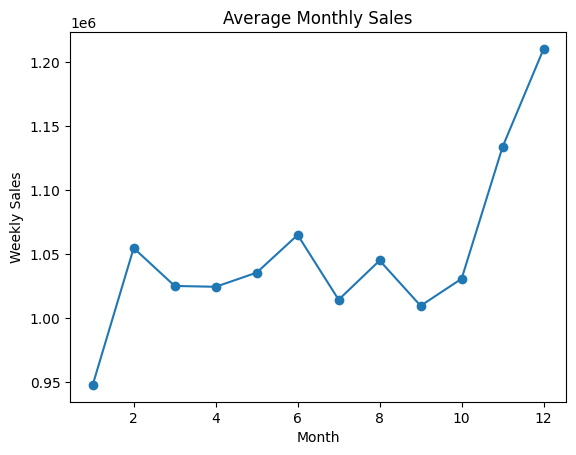

In [17]:
df['Month'] = df['Date'].dt.month

monthly_sales = df.groupby('Month')['Weekly_Sales'].mean()

plt.figure()
monthly_sales.plot(marker='o')
plt.title("Average Monthly Sales")
plt.xlabel("Month")
plt.ylabel("Weekly Sales")
plt.show()


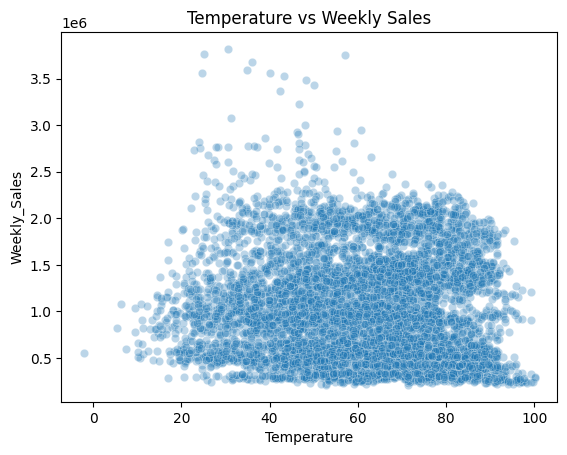

In [18]:
plt.figure()
sns.scatterplot(x='Temperature', y='Weekly_Sales', data=df, alpha=0.3)
plt.title("Temperature vs Weekly Sales")
plt.show()


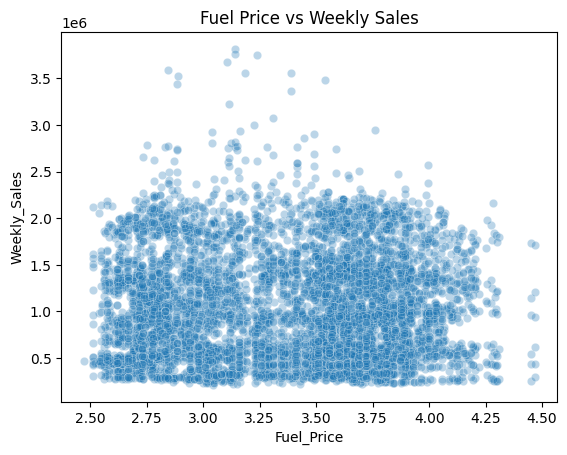

In [19]:
plt.figure()
sns.scatterplot(x='Fuel_Price', y='Weekly_Sales', data=df, alpha=0.3)
plt.title("Fuel Price vs Weekly Sales")
plt.show()


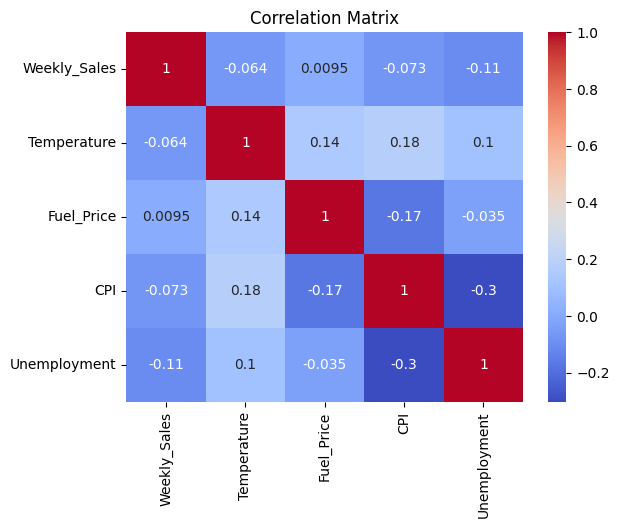

In [20]:
features = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

plt.figure()
sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [21]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [23]:
df['Date'] = pd.to_datetime(df['Date'])

# Time features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week.astype(int)

# Sort for time-based split
df = df.sort_values('Date')

train = df[df['Date'] < '2012-01-01']
test  = df[df['Date'] >= '2012-01-01']

X_train = train.drop(['Weekly_Sales', 'Date'], axis=1)
y_train = train['Weekly_Sales']

X_test = test.drop(['Weekly_Sales', 'Date'], axis=1)
y_test = test['Weekly_Sales']


In [24]:
lr = LinearRegression()

rf = RandomForestRegressor(
    n_estimators=150,
    max_depth=10,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

gb = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    random_state=42
)


In [25]:
ensemble = VotingRegressor(
    estimators=[
        ('lr', lr),
        ('rf', rf),
        ('gb', gb)
    ],
    weights=[1, 2, 3]  # GB emphasized
)


In [26]:
ensemble.fit(X_train, y_train)

pred_ensemble = ensemble.predict(X_test)


In [27]:
mae = mean_absolute_error(y_test, pred_ensemble)
rmse = np.sqrt(mean_squared_error(y_test, pred_ensemble))

print("Ensemble MAE:", mae)
print("Ensemble RMSE:", rmse)


Ensemble MAE: 164181.18632033863
Ensemble RMSE: 244687.8861013215
